## 1. Adatok betöltése

In [4]:
import os
from google.colab import files

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d matheuseduardo/preprocessed-2019-blindness-detection

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/matheuseduardo/preprocessed-2019-blindness-detection
License(s): unknown
 97% 553M/571M [00:04<00:00, 130MB/s]
100% 571M/571M [00:04<00:00, 132MB/s]


In [5]:
!unzip preprocessed-2019-blindness-detection.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: test_images/512beaada8f0.jpg  
  inflating: test_images/51323e9d2070.jpg  
  inflating: test_images/515675001b9e.jpg  
  inflating: test_images/515877da2def.jpg  
  inflating: test_images/5168ddccea88.jpg  
  inflating: test_images/5172c056a687.jpg  
  inflating: test_images/5177461f5339.jpg  
  inflating: test_images/51910bcb980d.jpg  
  inflating: test_images/51a3e9b6a1c0.jpg  
  inflating: test_images/51bbd82feec8.jpg  
  inflating: test_images/51de5fb8eccd.jpg  
  inflating: test_images/51e88694c81f.jpg  
  inflating: test_images/51f0bf8f1544.jpg  
  inflating: test_images/51f57fb32840.jpg  
  inflating: test_images/51fa42dc1415.jpg  
  inflating: test_images/5276ab33b7b0.jpg  
  inflating: test_images/52a353760f72.jpg  
  inflating: test_images/531937254e73.jpg  
  inflating: test_images/5325b1c22c61.jpg  
  inflating: test_images/53959e0a750b.jpg  
  inflating: test_images/53be22c72713.jpg  
  inflating: test_images/

## 2. Könyvtárak importolásáa

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

## 3. Adatok betöltése

In [ ]:
data_dir = '/content/train_images'
labels_dir = '/content/train.csv'

In [ ]:
labels_df = pd.read_csv(labels_dir)

In [ ]:
print(data_dir)
print(labels_dir)

/content/train_images
/content/train.csv


In [ ]:
data = []
labels = []

In [ ]:
for i in range(len(labels_df)):
    img_name = labels_df.iloc[i, 0]
    img_label = labels_df.iloc[i, 1]
    img = cv2.imread(os.path.join(data_dir, img_name))
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(img_label)

In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
# Pixelek normalizálása
# data = data / 255.0

In [ ]:
print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

## 4. Augmentálás

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## 5. Modell definiálás

In [ ]:
# Load EfficientNet as base model
base_model = EfficientNetB0(
    weights='imagenet',           # Use pretrained ImageNet weights
    include_top=False,            # Remove the top classification layers
    input_shape=(224, 224, 3)     # Resized images
)

# Freeze base model
base_model.trainable = False

# Build the full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression output
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 6. Early Stopping és Learning rate

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

## 7. Betanítás

In [ ]:
# Modell betanítása
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=100,
    validation_data=test_datagen.flow(X_test, y_test, batch_size=32),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 165ms/step - loss: 1.1111 - mae: 0.7685 - val_loss: 0.5486 - val_mae: 0.4827 - learning_rate: 0.0010
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5739 - mae: 0.5301 - val_loss: 0.4860 - val_mae: 0.4848 - learning_rate: 0.0010
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5658 - mae: 0.5009 - val_loss: 0.5609 - val_mae: 0.5765 - learning_rate: 0.0010
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5174 - mae: 0.4703 - val_loss: 0.5902 - val_mae: 0.4387 - learning_rate: 0.0010
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4944 - mae: 0.4569 - val_loss: 0.4301 - val_mae: 0.4133 - learning_rate: 0.0010
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4915 - mae: 0.4475 - val_loss: 0.4429 - val_mae: 0.3754 - learning_rate: 0.0010
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4427 - mae: 0.4116 - val_loss: 0.4228 - val_mae: 0.3809 - learning_rate: 0.0010
Ep

## 8. Kiértékelés

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       351
           1       0.57      0.37      0.45        68
           2       0.71      0.77      0.73       213
           3       0.22      0.47      0.30        36
           4       0.69      0.17      0.27        65

    accuracy                           0.77       733
   macro avg       0.63      0.55      0.54       733
weighted avg       0.79      0.77      0.76       733



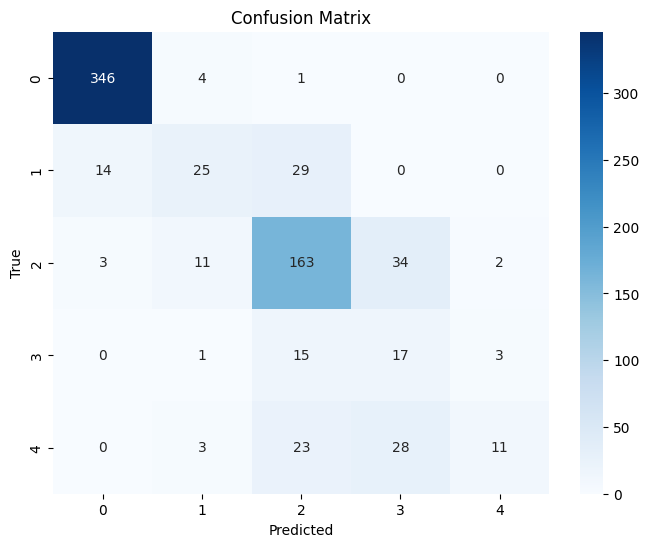

In [ ]:
# Make predictions
y_pred = model.predict(X_test).flatten()  # Flatten to ensure 1D array

# Round predictions to nearest integer
y_pred_rounded = np.rint(y_pred).astype(int)

# Ensure predictions stay within valid label range
y_pred_rounded = np.clip(y_pred_rounded, y_test.min(), y_test.max())

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rounded))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Heatmap of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Teszt veszteség: {test_loss}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - loss: 0.3482 - mae: 0.3466
Teszt veszteség: 0.353483647108078


## 9. Mentés

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_save_path = '/content/drive/MyDrive/DR_EfficientNet_APTOS_Regression_Final.keras'

model.save(model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
import json

metrics = {
    "train_accuracy": history.history["accuracy"],
    "train_loss": history.history["loss"],
    "val_accuracy": history.history["val_accuracy"],
    "val_loss": history.history["val_loss"]
}

with open("DR_EfficientNet_APTOS_Regression_Final_metrics.json", "w") as f:
    json.dump(metrics, f)

!cp metrics.json /content/drive/MyDrive/

## 10. Törlés új beállításhoz

In [ ]:
from tensorflow.keras import backend as K

# Delete model and free memory
del model
K.clear_session()


In [ ]:
history = None